### DHO Likehood Surface Visualization

<br>**Author(s):** Weixiang Yu
<br>**Last run:** 09-01-20
<br>**Short description:** Notebook for developing the likelihood surface visualization function for DHOs. 

In [23]:
%load_ext autoreload
%autoreload 2

In [1]:
# import basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, sys
%matplotlib inline

# see if local stores mpl style, else use from src
mpl.rc_file('https://raw.githubusercontent.com/ywx649999311/project_template'
            '/master/%7B%7Bcookiecutter.project_name%7D%7D/src/vis/mpl/yu_basic.rc')

pd.set_option('display.max_columns', 999)

In [2]:
# import CARMA celerite term
from agntk.carma.CARMATerm import *
from agntk.lc.utils import *
from celerite import GP
from scipy.optimize import minimize, differential_evolution
import dask

### 1. Simulate LC

In [3]:
# define GP model
a1 = 0.03939692
a2 = 0.00027941
b0 = 0.0046724
b1 = 0.0256982
kernel = DHO_term(np.log(a1), np.log(a2), np.log(b0), np.log(b1))
gp = GP(kernel)

# check if Celerite give the same amp as Kali
assert np.allclose(1.0, kernel.get_amp())

Text(0.5, 1.0, 'Full Simulated DHO LC')

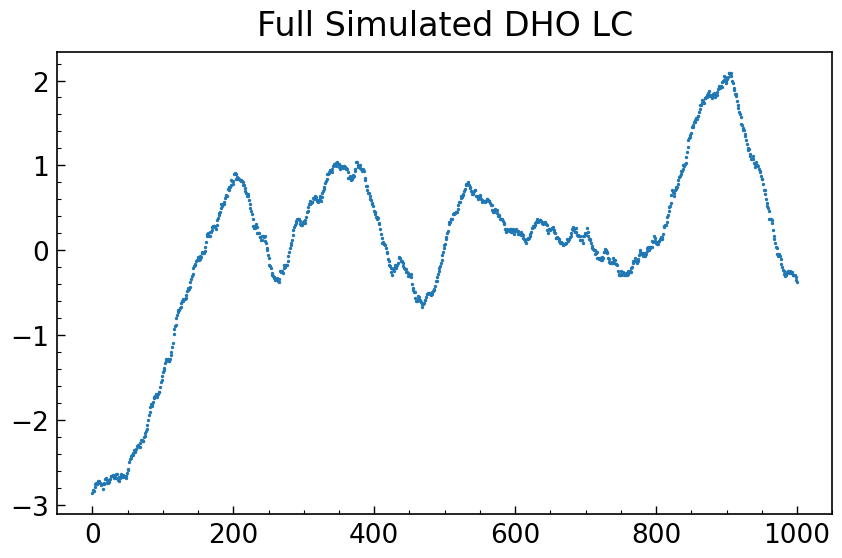

In [4]:
# sim Full DHO LC with 1000 days to compare with Kali example
t_full = np.linspace(0, 1000, 1000)
yerr_full = np.random.normal(0, 1e-7, 1000) # give very tiny error

gp.compute(t_full, yerr_full)
y_full = gp.sample()

# # plot simulated LC
fig = plt.figure(figsize=(10,6))
plt.scatter(t_full, y_full, s=2)
plt.title('Full Simulated DHO LC')

In [5]:
# now simulate 10 years LC
npts = 100

# init with dense -> add season -> downsample
t_init = np.linspace(0, 3650, 10000)
yerr_init = np.random.normal(0, 1e-7, 10000) # give very tiny error
mask1 = add_season(t_init)
mask2 = downsample_byN(t_init[mask1], 100)
t = t_init[mask1][mask2]
yerr = yerr_init[mask1][mask2]

gp.set_parameter_vector(np.log([a1, a2, b0, b1]))
gp.compute(t, yerr)

# simulate LC
y = gp.sample()

print(f'Sim Std: {np.std(y)}')

Sim Std: 1.0656787565828754


Text(0.5, 1.0, 'Simulated DHO LC with Seasonal Gap')

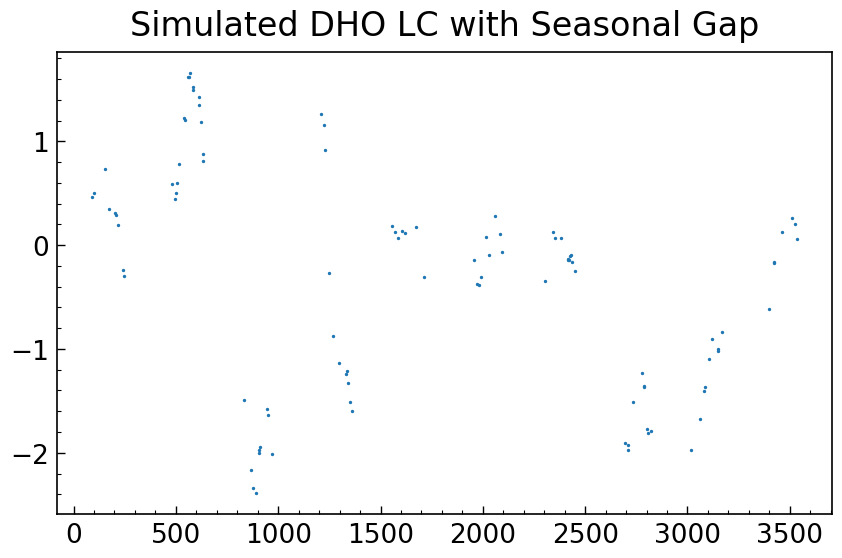

In [6]:
# # plot simulated LC
fig = plt.figure(figsize=(10,6))
plt.scatter(t, y, s=2)
plt.title('Simulated DHO LC with Seasonal Gap')

### 2. Generate best-fits & Eval LL Surface
#### 2.1 First fit using optimizer

In [7]:
# define log posterior function
def neg_ll(params, y, yerr, gp):
    """This method will catch 'overflow/underflow' runtimeWarning and 
    return -inf as probablility
    """
    # change few runtimewarning action setting
    notify_method = "raise"
    np.seterr(over=notify_method)
    np.seterr(under=notify_method)

    params = np.array(params)
    run = True
    lap = 0

    while run:
        if lap > 50:
            return -np.inf

        lap += 1
        try:
            gp.set_parameter_vector(params)
            neg_ll = -gp.log_likelihood(y)
            run = False
        except celerite.solver.LinAlgError:
            params += 1e-6 * np.random.randn(4)
            continue
        except np.linalg.LinAlgError:
            params += 1e-6 * np.random.randn(4)
            continue
        except FloatingPointError:
            return -np.inf

    return neg_ll


# # define vectorized version
vec_neg_ll = np.vectorize(neg_ll, excluded=[1,2,3], signature='(n)->()')

In [8]:
def fitDHO(t, y, yerr, prob_func, debug=False):
    # check dimention dismatch
    assert (len(t) == len(yerr)) & (len(t) == len(y)), 'Data dimension dismatch.'

    ## start fitting
    # initialize parameter in the possible range
    a1 = np.exp(np.random.uniform(-10, 1, 1)[0])
    a2 = np.exp(np.random.uniform(-14, -3, 1)[0])
    b0 = np.exp(np.random.uniform(-10, -5, 1)[0])
    b1 = np.exp(np.random.uniform(-10, -5, 1)[0])

    kernel_fit = DHO_term(np.log(a1), np.log(a2), np.log(b0), np.log(b1))
    gp_fit = GP(kernel_fit)
    gp_fit.compute(t, yerr)

    bounds = [(-10, 7), (-14, 7), (-12, -2), (-11, -2)]

    ret = differential_evolution(prob_func, bounds, args=(y, yerr, gp_fit))
    
    if debug:
        print(r)
    
    return ret.x

In [9]:
# fit with log_like or log_prob
ll_fit = np.exp(fitDHO(t, y, yerr, neg_ll))

print(f'LogLikelihood best-fit: {ll_fit}')
print(f'True: {[a1, a2, b0, b1]}')

LogLikelihood best-fit: [0.04500455 0.00027324 0.00508681 0.02183163]
True: [0.03939692, 0.00027941, 0.0046724, 0.0256982]


In [10]:
gp.set_parameter_vector(np.log(ll_fit))
print (f'Amp: {gp.kernel.get_amp()}')
gp.log_likelihood(y)

Amp: 1.0282960570058102


28.90383131437305

In [11]:
gp.set_parameter_vector(np.log([a1, a2, b0, b1]))
print (f'Amp: {gp.kernel.get_amp()}')
gp.log_likelihood(y)

Amp: 1.0000012851313507


28.381202222279924

#### 1.2 Check out the likelihood surface

In [12]:
print(f'Best-fit in log: {np.log(ll_fit)}')
print(f'True in log:{np.log([a1, a2, b0, b1])}')

Best-fit in log: [-3.10099175 -8.20515167 -5.28110521 -3.82439525]
True in log:[-3.23406764 -8.18283032 -5.36608242 -3.66133433]


In [13]:
# eval likelihood surface
# init grid, range is 1 times best-fit
best_log = np.log(ll_fit)
num_param = len(ll_fit)
param_range = np.zeros((num_param, 2))

for i in range(num_param):
    param_range[i, :] = [best_log[i]-1, best_log[i]+1]
    
inner_dim = 10
outer_dim = 5

inner_grid_params = [0, 1]
outer_grid_params = [2, 3]

grid_ls = []

for i in range(num_param):
    pm_range = param_range[i]
    
    # check if param is in inner grid
    if i in inner_grid_params:
        grid_ls.append(np.linspace(pm_range[0], pm_range[1], inner_dim))
    else:
        wide_grid = np.linspace(pm_range[0], pm_range[1], outer_dim+1)
        delta = wide_grid[1] - wide_grid[0]
        grid_ls.append(wide_grid[1:]-delta/2)

In [14]:
param_grid = np.meshgrid(*grid_ls) # log scale
reg_param_grid = np.exp(param_grid) # normal scale
gp.compute(t, yerr)

In [15]:
%%time
# run in np.vectorize
param_combos = zip(param_grid[0].flatten(), param_grid[1].flatten(),\
                   param_grid[2].flatten(), param_grid[3].flatten())
ls_param_combos = list(param_combos)
bulk_ll = - vec_neg_ll(ls_param_combos, y, yerr, gp)

CPU times: user 2.06 s, sys: 12.2 ms, total: 2.07 s
Wall time: 2.07 s


In [59]:
%%time
# use dask delayed
param_combos = zip(param_grid[0].flatten(), param_grid[1].flatten(),\
                   param_grid[2].flatten(), param_grid[3].flatten())

dask_ls = []
for param_combo in param_combos:
    dask_ls.append(dask.delayed(neg_ll)(param_combo, y, yerr, gp))
    
dask_ll = - [ll.compute() for ll in dask_ls]

CPU times: user 810 ms, sys: 123 ms, total: 933 ms
Wall time: 852 ms


<span style='color:red'>__Remark:__</span> Numpy's vectorize is slighly faster then dask.delayed.

In [16]:
# back to shape (dim, dim, dim, dim)
dims = np.empty(num_param, dtype=np.int)
dims[inner_grid_params] = inner_dim
dims[outer_grid_params] = outer_dim

In [17]:
# bulk_ll -= (bulk_ll.min() - 0.1)
max_ll, min_ll = np.max(bulk_ll), np.min(bulk_ll)
ll_reshape = bulk_ll.reshape(tuple(dims))
idx_max = np.unravel_index(np.argmax(ll_reshape, axis=None), ll_reshape.shape)

print(f'Max/Min LL: {max_ll, min_ll}')
print(f'Index of grid obtained max ll: {idx_max}')

Max/Min LL: (28.62636752106802, -641.1191713871265)
Index of grid obtained max ll: (5, 4, 2, 2)


/Users/weixiang/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
  if __name__ == '__main__':


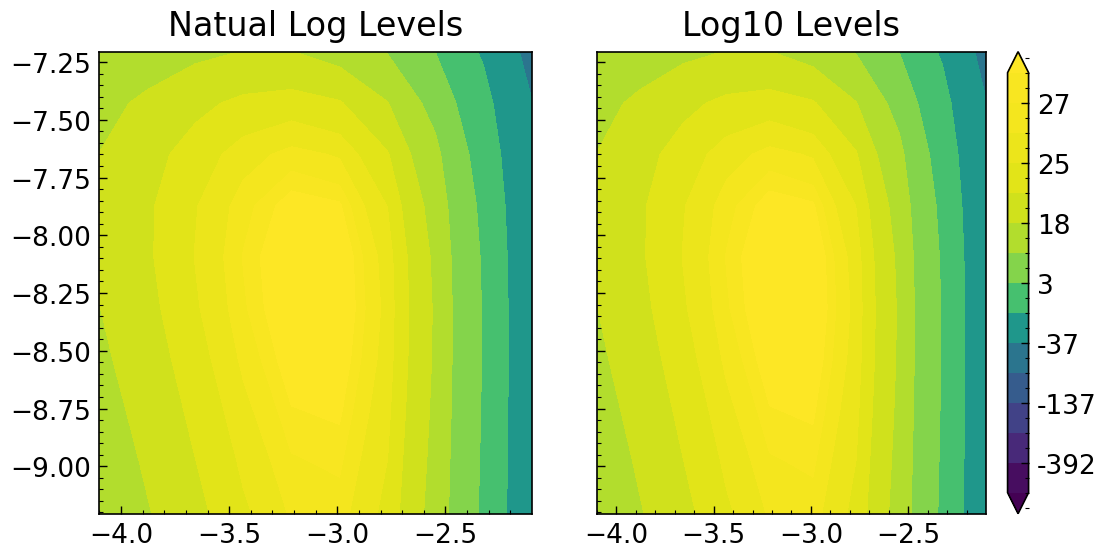

In [21]:
i = idx_max[2]
j = idx_max[3]
fig, axes = plt.subplots(1,2, figsize=(12,6), sharex=True, sharey=True)

# create log levels & SymLogNorm
nLevels = 15
log_levels = max_ll - np.logspace(0, np.log(max_ll - min_ll), nLevels, base=np.e)[::-1]
log10_levels = max_ll - np.logspace(0, np.log10(max_ll - min_ll), nLevels)[::-1]
norm = mpl.colors.SymLogNorm(linthresh=np.abs(max_ll), linscale=1, vmin=min_ll, vmax=max_ll)
# norm = mpl.colors.Normalize(vmin=min_ll, vmax=max_ll)

_ = axes[0].contourf(param_grid[0][:,:, i, j], param_grid[1][:,:, i, j], \
                     ll_reshape[:,:, i, j], log_levels, norm=norm, extend='both')
_ = axes[1].contourf(param_grid[0][:,:, i, j], param_grid[1][:,:, i, j], \
                     ll_reshape[:,:, i, j], log10_levels, norm=norm, extend='both')

axes[0].set_title('Natual Log Levels')
axes[1].set_title('Log10 Levels')
                         
fig.colorbar(_, fraction=0.05, format='%.0f')

/Users/weixiang/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.


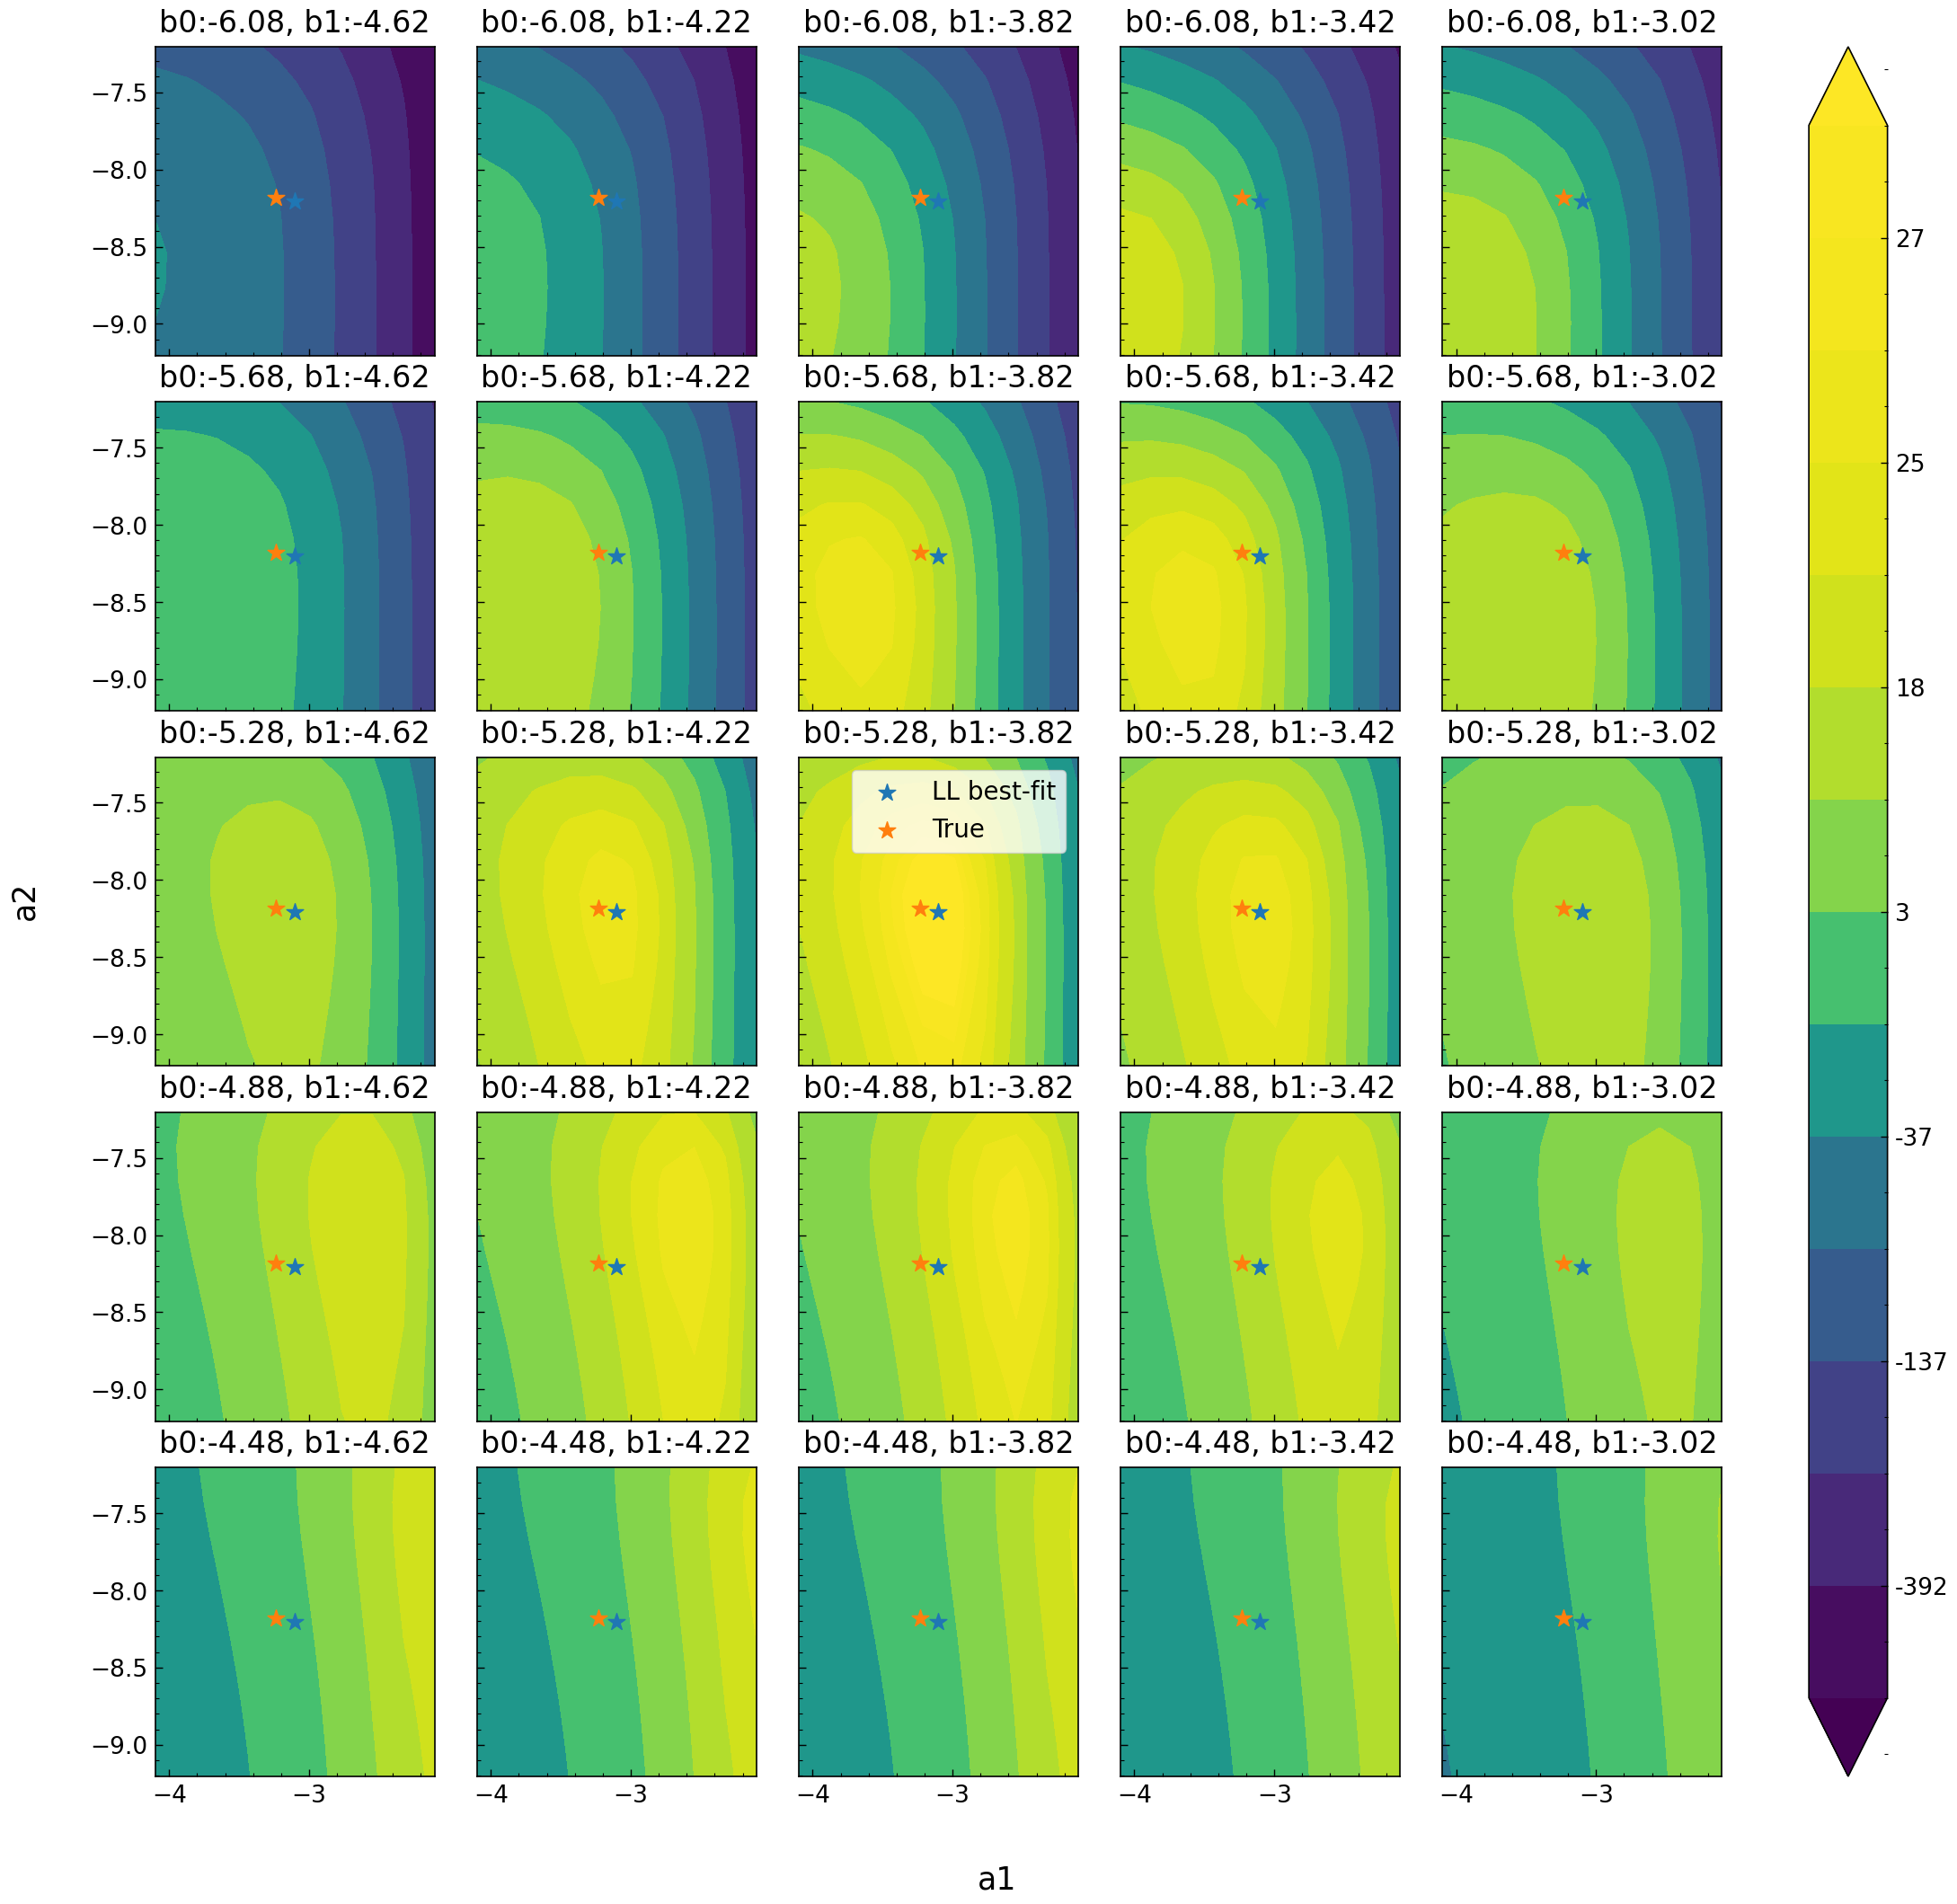

In [24]:
# plot
figsize = (outer_dim*5, outer_dim*5)
fig, axs = plt.subplots(outer_dim, outer_dim, figsize=figsize, sharey=True, sharex=True)
images =  {}

b0s = grid_ls[2]
b1s = grid_ls[3]

for i in range(outer_dim):
    for j in range(outer_dim):
        _ = axs[i, j].contourf(param_grid[0][:,:, i, j], param_grid[1][:,:, i, j], \
                     ll_reshape[:,:, i, j], log10_levels, extend='both')
        images[f'{i}_{j}'] = _
        # plt.contour(reg_grid[0], reg_grid[1], -ll_reshape, nLevels,colors="white")
#         plt.xlabel("a1")
#         plt.ylabel("a2")
        axs[i, j].scatter(best_log[0], best_log[1], marker='*', s=200, \
                    label='LL best-fit')
        axs[i, j].scatter(np.log(a1), np.log(a2), marker='*', s=200, label='True')
        axs[i, j].set_title(f'b0:{b0s[i]:.2f}, b1:{b1s[j]:.2f}')

norm = mpl.colors.SymLogNorm(linthresh=np.abs(max_ll), linscale=1, vmin=min_ll, vmax=max_ll)
for key in images:
    images[key].set_norm(norm)


fig.colorbar(images[f'{idx_max[2]}_{idx_max[3]}'], ax=axs, fraction=.05, format='%.0f')
fig.text(0.5, 0.06, 'a1', ha='center', fontsize=25)
fig.text(0.06, 0.5, 'a2', va='center', rotation='vertical', fontsize=25)
axs[idx_max[2],idx_max[3]].legend()

In [21]:
print(f'Best-fit in log10: {best_log}')
print(f'True in log10:{np.log([a1, a2, b0, b1])}')

Best-fit in log10: [-3.20867825 -8.80497678 -5.36064347 -3.59258184]
True in log10:[-3.23406764 -8.18283032 -5.36608242 -3.66133433]


<span style='color:red'>Based on the likelihood surface plot, we can see the algorithm indeed found the best solution given the surface, but the best-fit doesn't agree with the input used. </span>

### 3. Put above code into a function

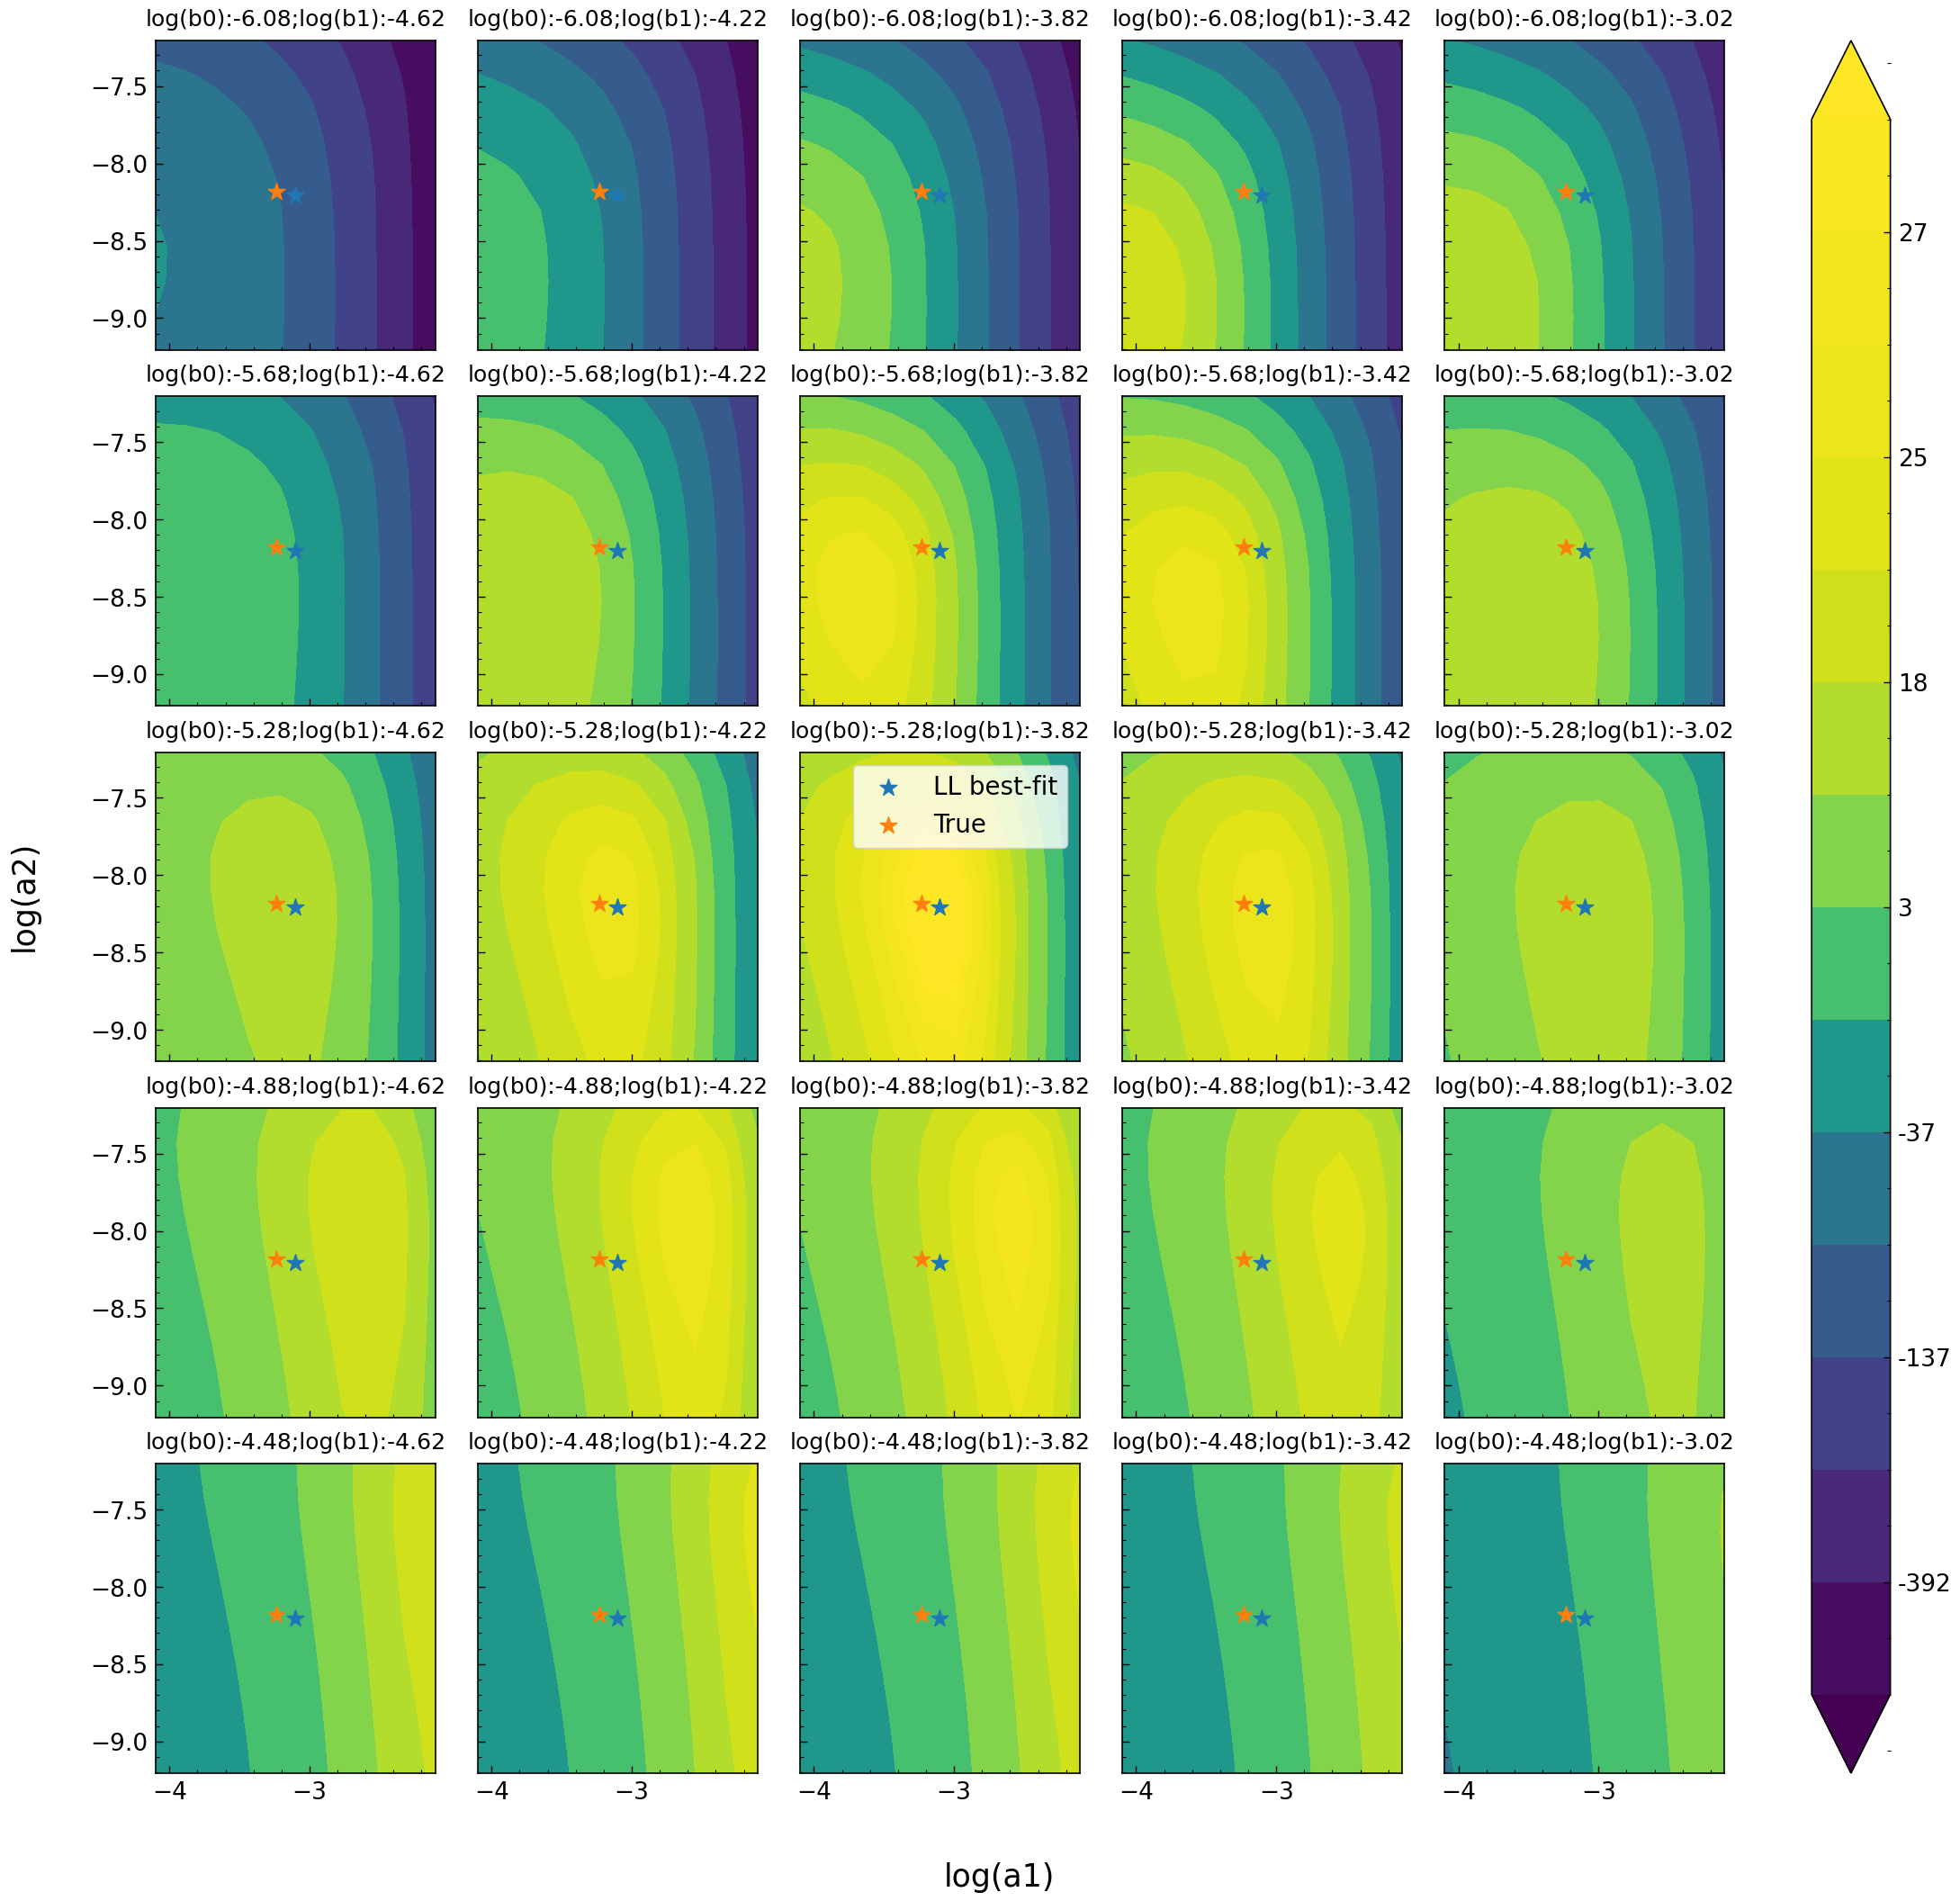

In [25]:
from agntk.viz.mpl_viz import *
plot_dho_ll(t, y, yerr, ll_fit, gp, neg_ll, outer_dim=5, nLevels=15,
            ranges=[(None, None), (None, None), (None, None), (None, None)],
           true_params=np.log([a1, a2, b0, b1]))

In [57]:
def plot_dho_ll(t, y, yerr, best_params, gp, prob_func, inner_dim=10, outer_dim=4,
                ranges=[(None, None), (None, None), (None, None), (None, None)], 
                nLevels=20, **kwargs):

    best_log = np.log(best_params)
    num_param = len(best_log)
    param_range = np.zeros((num_param, 2))
    
    # check if any ranges provided
    for i in range(num_param):
        if any(map(lambda x: x is None, ranges[i])):
            param_range[i, :] = np.array([best_log[i]-1, best_log[i]+1])
        else:
            param_range[i, :] = np.array(ranges[i])
        
    # create meshgrid to compute ll
    inner_grid_params = [0, 1]
    outer_grid_params = [2, 3]
    grid_ls = []
    
    for i in range(num_param):
        pm_range = param_range[i]

        # check if param is in inner grid
        if i in inner_grid_params:
            grid_ls.append(np.linspace(pm_range[0], pm_range[1], inner_dim))
        else:
            wide_grid = np.linspace(pm_range[0], pm_range[1], outer_dim+1)
            delta = wide_grid[1] - wide_grid[0]
            grid_ls.append(wide_grid[1:]-delta/2)

    param_grid = np.meshgrid(*grid_ls) # log scale
    reg_param_grid = np.exp(param_grid) # normal scale
    
    # prepare for np.vectorize
    vec_neg_ll = np.vectorize(prob_func, excluded=[1,2,3], signature='(n)->()')
    param_combos = zip(param_grid[0].flatten(), param_grid[1].flatten(),\
                       param_grid[2].flatten(), param_grid[3].flatten())
    ls_param_combos = list(param_combos)
    
    # run in bulk
    gp.compute(t, yerr)
    bulk_ll = np.negative(vec_neg_ll(ls_param_combos, y, yerr, gp))
    
    # back to shape (dim, dim, dim, dim)
    dims = np.empty(num_param, dtype=np.int)
    dims[inner_grid_params] = inner_dim
    dims[outer_grid_params] = outer_dim
    
    ll_reshape = bulk_ll.reshape(tuple(dims))
    max_ll, min_ll = np.max(bulk_ll), np.min(bulk_ll)
    idx_max = np.unravel_index(np.argmax(ll_reshape, axis=None), ll_reshape.shape)
    log_levels = max_ll - np.logspace(0, np.log10(max_ll - min_ll), nLevels)[::-1]

    # plot
    figsize = (outer_dim*5, outer_dim*5)
    fig, axs = plt.subplots(outer_dim, outer_dim, figsize=figsize, sharey=True, sharex=True)
    images =  {}

    b0s = grid_ls[2]
    b1s = grid_ls[3]
    
    # loop over each grid point on outler layer
    for i in range(outer_dim):
        for j in range(outer_dim):
            _ = axs[i, j].contourf(param_grid[0][:,:, i, j], param_grid[1][:,:, i, j], \
                         ll_reshape[:,:, i, j], log_levels, extend="both")
            images[f'{i}_{j}'] = _
            axs[i, j].scatter(best_log[0], best_log[1], marker='*', s=200, \
                        label='LL best-fit')
            if "true_params" in kwargs:
                true_params = kwargs.get("true_params")
                axs[i, j].scatter(true_params[0], true_params[1], marker="*", s=200, label="True")
            
            axs[i, j].set_title(f'log(b0):{b0s[i]:.2f};log(b1):{b1s[j]:.2f}', fontsize=18)
    
    # reset the norm
    norm = mpl.colors.SymLogNorm(linthresh=np.abs(max_ll), linscale=1, vmin=min_ll, vmax=max_ll)
    for key in images:
        images[key].set_norm(norm)

    fig.colorbar(images[f'{idx_max[2]}_{idx_max[3]}'], ax=axs, fraction=.05, format='%.0f')
    fig.text(0.5, 0.06, 'log(a1)', ha='center', fontsize=25)
    fig.text(0.06, 0.5, 'log(a2)', va='center', rotation='vertical', fontsize=25)
    axs[idx_max[2], idx_max[3]].legend()